In [ ]:
#default_exp gt
from nbdev.showdoc import show_doc, add_docs

# Ground Truth Estimation

> Implements functions for ground truth estimation from the annotations of multiple experts. Based on [SimpleITK](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/34_Segmentation_Evaluation.html).

In [ ]:
#hide 
from deepflash2.gui import _get_expert_sample_masks

In [ ]:
#export
import imageio, pandas as pd, numpy as np
from pathlib import Path
from fastcore.basics import GetAttr
from fastprogress import progress_bar
from fastai.data.transforms import get_image_files
import matplotlib.pyplot as plt

from deepflash2.data import _read_msk
from deepflash2.learner import Config
from deepflash2.utils import save_mask, dice_score, install_package

## Helper Functions

Installing [SimpleITK](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/34_Segmentation_Evaluation.html), which is not a dependency of `deepflash2`.

In [ ]:
#export
def import_sitk():
    try:
        import SimpleITK
        assert SimpleITK.Version_MajorVersion()==2
    except:
        print('Installing SimpleITK. Please wait.')
        install_package("SimpleITK==2.0.2")
    import SimpleITK
    return SimpleITK

## Ground Truth Estimation

### Simultaneous truth and performance level estimation (STAPLE) 

The STAPLE algorithm considers a collection of segmentations and computes a probabilistic estimate of the true segmentation and a measure of the performance level represented by each segmentation. 

_Source: Warfield, Simon K., Kelly H. Zou, and William M. Wells. "Simultaneous truth and performance level estimation (STAPLE): an algorithm for the validation of image segmentation." IEEE transactions on medical imaging 23.7 (2004): 903-921_

In [ ]:
#export
def staple(segmentations, foregroundValue = 1, threshold = 0.5):
    'STAPLE: Simultaneous Truth and Performance Level Estimation with simple ITK'
    sitk = import_sitk()
    segmentations = [sitk.GetImageFromArray(x) for x in segmentations]
    STAPLE_probabilities = sitk.STAPLE(segmentations)
    STAPLE = STAPLE_probabilities > threshold
    #STAPLE = sitk.GetArrayViewFromImage(STAPLE)
    return sitk.GetArrayFromImage(STAPLE)

### Majority Voting
Use majority voting to obtain the reference segmentation. Note that this filter does not resolve ties. In case of ties it will assign the backgtound label (0) to the result. 

In [ ]:
#export
def m_voting(segmentations, labelForUndecidedPixels = 0):
    'Majority Voting from  simple ITK Label Voting'
    sitk = import_sitk()
    segmentations = [sitk.GetImageFromArray(x) for x in segmentations]
    mv_segmentation = sitk.LabelVoting(segmentations, labelForUndecidedPixels)
    return sitk.GetArrayFromImage(mv_segmentation)

### GT Estimator

Class for ground truth estimation

In [ ]:
#export
from mpl_toolkits.axes_grid1 import make_axes_locatable
def msk_show(ax, msk, title, cbar=None, ticks=None, **kwargs):
    img = ax.imshow(msk, **kwargs)
    if cbar is not None:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        if cbar=='plot': 
            scale = ticks/(ticks+1)
            cbr = plt.colorbar(img, cax=cax, ticks=[i*(scale)+(scale/2) for i in range(0, ticks+1)])
            cbr.set_ticklabels([i for i in range(0, ticks+1)])
            cbr.set_label('# of experts', rotation=270, labelpad=+15, fontsize="larger")
        else: cax.set_axis_off()
    ax.set_axis_off()
    ax.set_title(title)            

In [ ]:
#export
class GTEstimator(GetAttr):
    "Class for ground truth estimation"
    _default = 'config' 
    
    def __init__(self, exp_dir='expert_segmentations', config=None, path=None, cmap='viridis' , verbose=1):
        self.exp_dir = exp_dir
        self.config = config or Config()
        self.path = Path(path) if path is not None else Path('.')
        self.mask_fn = lambda exp,msk: self.path/self.exp_dir/exp/msk
        self.cmap = cmap
        self.gt = {}
        
        f_list = get_image_files(self.path/self.exp_dir)
        assert len(f_list)>0, f'Found {len(f_list)} masks in "{self.path/self.exp_dir}". Please check your masks and expert folders.'
        ass_str = f'Found unexpected folder structure in {self.path/self.exp_dir}. Please check your provided masks and folders.'
        assert len(f_list[0].relative_to(self.path/self.exp_dir).parents)==2, ass_str
              
        self.masks = {}
        self.experts = []
        for m in sorted(f_list):
            exp = m.parent.name
            if m.name in self.masks:
                self.masks[m.name].append(exp)
            else:
                self.masks[m.name] = [exp]
            self.experts.append(exp)
        self.experts = sorted(set(self.experts))
        if verbose>0: print(f'Found {len(self.masks)} unique segmentation mask(s) from {len(self.experts)} expert(s)')
                   
    def show_data(self, max_n=6, files=None, figsize=None, **kwargs):
        if files is not None:
            files = [(m,self.masks[m]) for m in files]
        else:
            max_n = min((max_n, len(self.masks)))
            files = list(self.masks.items())[:max_n]
        if not figsize: figsize = (len(self.experts)*3,3)
        for m, exps in files:
            fig, axs = plt.subplots(nrows=1, ncols=len(exps), figsize=figsize, **kwargs)
            for i, exp in enumerate(exps):
                msk = _read_msk(self.mask_fn(exp,m))
                msk_show(axs[i], msk, exp, cmap=self.cmap)
            fig.text(0, .5, m, ha='center', va='center', rotation=90)
            plt.tight_layout()
            plt.show()
    
    def gt_estimation(self, method='STAPLE', save_dir=None, filetype='.png', **kwargs):
        assert method in ['STAPLE', 'majority_voting']
        res = []
        refs = {}
        print(f'Starting ground truth estimation - {method}')
        for m, exps in progress_bar(self.masks.items()):
            masks = [_read_msk(self.mask_fn(exp,m)) for exp in exps]
            if method=='STAPLE': 
                ref = staple(masks, self.staple_fval, self.staple_thres)
            elif method=='majority_voting':
                ref = m_voting(masks, self.mv_undec)
            refs[m] = ref
            #assert ref.mean() > 0, 'Please try again!'
            df_tmp = pd.DataFrame({'method': method, 'file' : m, 'exp' : exps, 'dice_score': [dice_score(ref, msk) for msk in masks]})
            res.append(df_tmp)
            if save_dir:  
                path = self.path/save_dir
                path.mkdir(exist_ok=True, parents=True)
                save_mask(ref, path/Path(m).stem, filetype)
        self.gt[method] = refs
        self.df_res = pd.concat(res)
        self.df_agg = self.df_res.groupby('exp').agg(average_dice_score=('dice_score', 'mean'), std_dice_score=('dice_score', 'std'))
        if save_dir: 
            self.df_res.to_csv(path.parent/f'{method}_vs_experts.csv', index=False)
            self.df_agg.to_csv(path.parent/f'{method}_vs_experts_agg.csv', index=False)
            with pd.ExcelWriter(path.parent/f'{method}_vs_experts.xlsx') as writer:  
                self.df_res.to_excel(writer, sheet_name='raw')
                self.df_agg.to_excel(writer, sheet_name='aggregated')
            
    def show_gt(self, method='STAPLE', max_n=6, files=None, figsize=(15,5), **kwargs):
        if not files: files = list(t.masks.keys())[:max_n]
        for f in files:
            fig, ax = plt.subplots(ncols=3, figsize=figsize, **kwargs)
            # GT
            msk_show(ax[0], self.gt[method][f], f'{method} (binary mask)', cbar='', cmap=self.cmap)
            # Experts
            masks = [_read_msk(self.mask_fn(exp,f)) for exp in self.masks[f]]
            masks_av = np.array(masks).sum(axis=0)#/len(masks)
            msk_show(ax[1], masks_av, 'Expert Overlay', cbar='plot', ticks=len(masks), cmap=plt.cm.get_cmap(self.cmap, len(masks)+1))
            # Results
            av_df = pd.DataFrame([self.df_res[self.df_res.file==f][['dice_score']].mean()], index=['average'], columns=['dice_score'])
            plt_df = self.df_res[self.df_res.file==f].set_index('exp')[['dice_score']].append(av_df)
            plt_df.columns = [f'Similarity (Dice Score)']
            tbl = pd.plotting.table(ax[2], np.round(plt_df,3), loc='center', colWidths=[.5])
            tbl.set_fontsize(14)
            tbl.scale(1, 2)
            ax[2].set_axis_off()
            fig.text(0, .5, f, ha='center', va='center', rotation=90)
            plt.tight_layout()
            plt.show()

In [ ]:
exp_dir = Path('deepflash2/sample_data/expert_segmentations')
_get_expert_sample_masks(exp_dir)
files=['0004_mask.png', '0001_mask.png']

In [ ]:
t = GTEstimator(exp_dir=exp_dir);

Found 5 unique segmentation mask(s) from 5 expert(s)


In [ ]:
#t.show_data(files=files);

Starting ground truth estimation - STAPLE


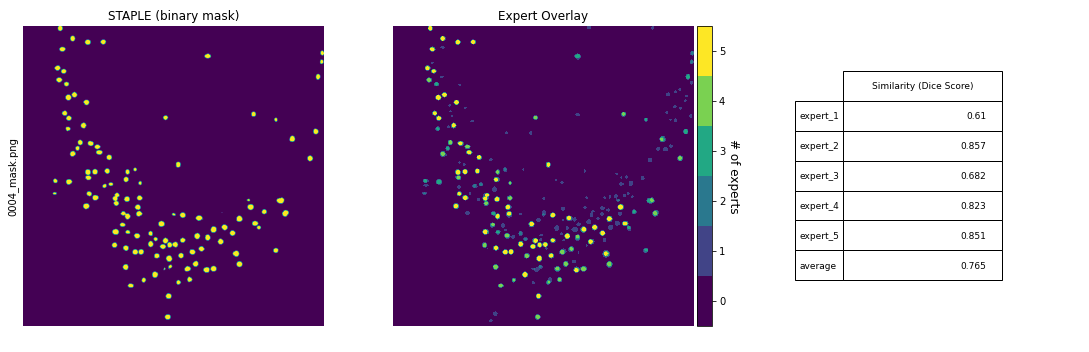

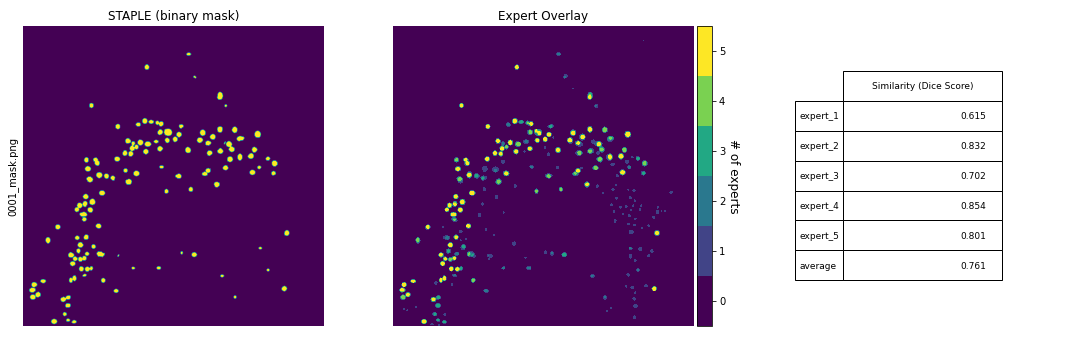

In [ ]:
t.gt_estimation()
t.show_gt(files=files)

Starting ground truth estimation - majority_voting


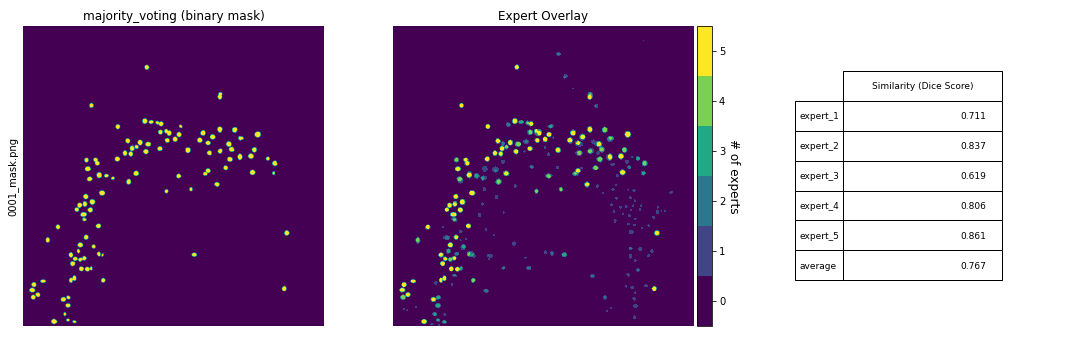

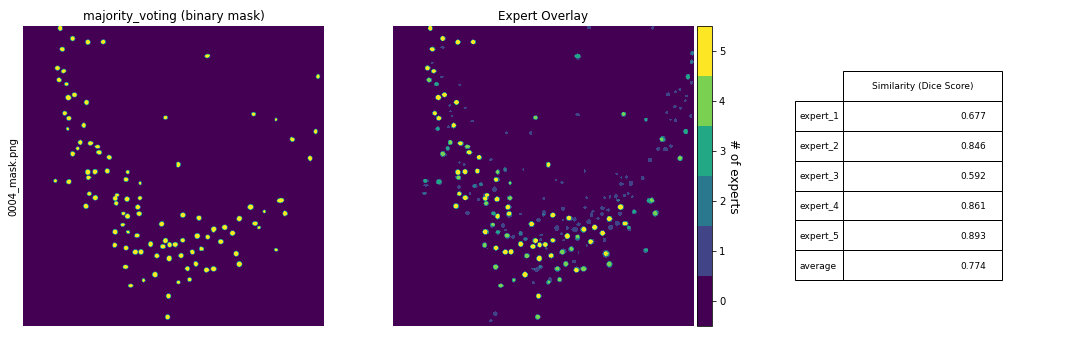

In [ ]:
t.gt_estimation(method='majority_voting', save_dir='mv_test')
t.show_gt(method='majority_voting', max_n=2)

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_learner.ipynb.
Converted 01_models.ipynb.
Converted 02_data.ipynb.
Converted 05_losses.ipynb.
Converted 06_utils.ipynb.
Converted 07_tta.ipynb.
Converted 08_gui.ipynb.
Converted 09_gt.ipynb.
Converted add_information.ipynb.
Converted gt_estimation.ipynb.
Converted index.ipynb.
Converted model_library.ipynb.
Converted predict.ipynb.
Converted train.ipynb.
Converted tutorial.ipynb.
